v2. This time output center point of ROI instead of upper left corner.

v3. Center x, y, w and h values around mean

v4. Don't center around mean, but center each ROI in the middle of it's cell by default. Use mean h and w as defaults.

v5. Normalize x, y to offset within grid cell, w, h to percentage of overall image size

v6. Setting values that had been 0 to some very small number to avoid sending params to inf or -inf. For a 4x4 grid there are a few cells which would contain more than one ROI. Rather than overwriting the previous one we combine the two into one larger ROI.

v7. Going to 2x2 grid. There are a max of 4 ROIs per image, if we combine ones that occur in the same cell this may work better.

v8. Trying a 3x3 grid instead.

v9. If the center of an ROI is within 5% of the border putting it in both cells instead of picking one.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import csv
import pickle
import os
import pydicom
%matplotlib inline

In [13]:
GRID_SIZE = 3
location_data = np.zeros((GRID_SIZE,GRID_SIZE,5))

for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        location_data[i,j,:] = [0, 390, 365, 225, 335]

In [14]:
img = pydicom.dcmread(os.path.join("stage_1_train_images", "cb4a1fca-136c-4577-bcef-d934c9f14f2c.dcm")).pixel_array

Below is an image which two ROIs in the same cell. The red boxes are the original ROIs, the blue is the new combined ROI.

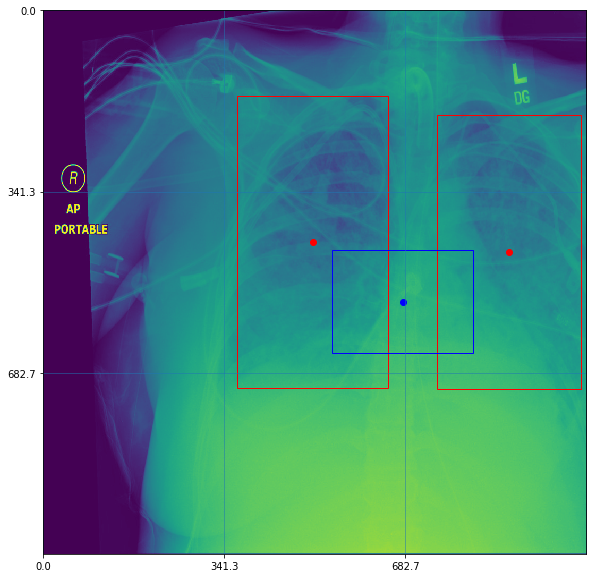

In [16]:
coords = np.arange(0, 1024, 1024 / GRID_SIZE)

# locs = [
#     [613,352,106,102],
#     [266,644,135,146],
#     [545,452,215,125],
#     [722,558,88,88]
# ]

locs = [
    [742,196,271,518],
    [365,162, 285, 549]
]

fig,ax = plt.subplots(1, figsize=(10,10))
plt.imshow(img)

for loc in locs:
    x,y,w,h = loc
    center_x = x + (w / 2)
    center_y = y + (h / 2)
    
    rect_1 = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')
    plt.plot(center_x, center_y, marker="o", color="r")
    ax.add_patch(rect_1)

rect_1 = patches.Rectangle((545,452),265,194,linewidth=1,edgecolor='b',facecolor='none')
plt.plot((545 + (265/2)), (452 + (194/2)), marker="o", color="b")
ax.add_patch(rect_1)    
    
plt.xticks(coords)
plt.yticks(coords)
for item in coords:
    plt.axvline(item, linewidth=0.5)
    plt.axhline(item, linewidth=0.5)
# plt.xlim(0,1024)
# plt.ylim(0,1024)
plt.show()

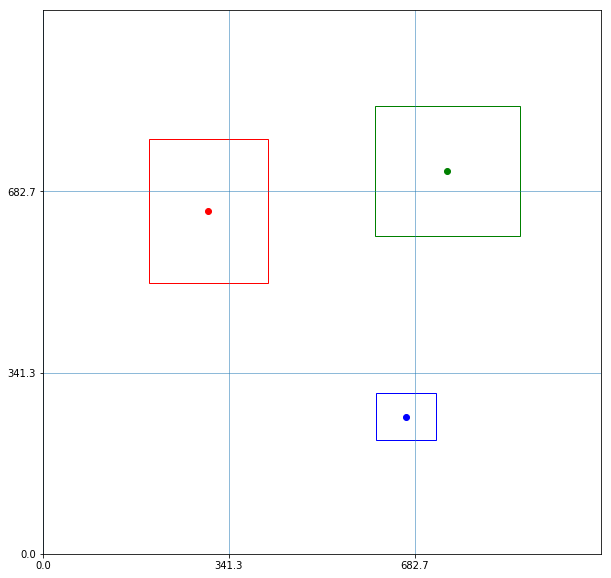

In [17]:
coords = np.arange(0, 1024, 1024 / GRID_SIZE)

fig,ax = plt.subplots(1, figsize=(10,10))

rect_1 = patches.Rectangle((195,511),218,271,linewidth=1,edgecolor='r',facecolor='none')
plt.plot(304, 646.5, marker="o", color="r")
rect_2 = patches.Rectangle((612,214),109,89,linewidth=1,edgecolor='b',facecolor='none')
plt.plot(666.5, 258.5, marker="o", color="b")
rect_3 = patches.Rectangle((610,599),265,245,linewidth=1,edgecolor='g',facecolor='none')
plt.plot(742.5, 721.5, marker="o", color="g")
ax.add_patch(rect_1)
ax.add_patch(rect_2)
ax.add_patch(rect_3)
plt.xticks(coords)
plt.yticks(coords)
for item in coords:
    plt.axvline(item, linewidth=0.5)
    plt.axhline(item, linewidth=0.5)
plt.xlim(0,1024)
plt.ylim(0,1024)
plt.show()

In [18]:
boxes = [
    [195,511,218,271],
    [612,214,109,89],
    [610,599,265,245]
]

centers = []

for box in boxes:
    x,y,w,h = box
    center_x = x + (w / 2)
    center_y = y + (h / 2)
    centers.append((center_x,center_y))

pixel_locs = []    
for center in centers:
    x_pixel = center[0] // 64
    y_pixel = center[1] // 64
    
    pixel_locs.append((x_pixel,y_pixel))
    
pixel_locs    

[(4.0, 10.0), (10.0, 4.0), (11.0, 11.0)]

In [19]:
ROOT_DIR = "./"

train_dicom_dir = os.path.join(ROOT_DIR, 'stage_1_train_images')
test_dicom_dir = os.path.join(ROOT_DIR, 'stage_1_test_images')
print("Train dir:", train_dicom_dir)

Train dir: ./stage_1_train_images


In [20]:
# get actual x and y values from sigmoid output and what cell they are in
def unnorm(val, idx, cell_size=256):
    x = (val * cell_size) + (cell_size * idx)
    return x

In [21]:
GRID_SIZE = 4
CELL_WIDTH = 1024 // GRID_SIZE

# means to center data
mu_x = 391.456158
mu_y = 363.1358768
mu_w = 220.8453815
mu_h = 334.1743641
mu_center_x = 501.8788487
mu_center_y = 530.2230589

num_dups = 0

# empty dictionary
pneumonia_locations = {}
used_filenames = []
pixel_means = []
locations = []
iffy_images = []
roi_sizes = []

# load table
with open(os.path.join('./stage_1_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        
        # initialize our data
        if filename not in used_filenames:
            location_data = np.zeros((GRID_SIZE,GRID_SIZE,5))
            
            # default label to mean values
            for i in range(GRID_SIZE):
                for j in range(GRID_SIZE):
                    y = ((i + 0.5) * CELL_WIDTH)
                    x = ((j + 0.5) * CELL_WIDTH)
                    location_data[i,j,:] = [0, 0.5, 0.5, 0.001, 0.001]
                    
            used_filenames.append(filename)
            locs = np.zeros((GRID_SIZE, GRID_SIZE))
        else:
            location_data = pneumonia_locations[filename]
            
        # if row contains pneumonia add label to dictionary
        # the dictionary will contain the presence, x, y, h, w of the pneumonia for each pixel in a 16x16 grid
        if pneumonia == '1':
            # extract the location and cast them to floats
            x,y,w,h = location
            x = float(x)
            y = float(y)
            w = float(w)
            h = float(h)
            
            # figure out the center of the ROI
            center_x = x + (w / 2)
            center_y = y + (h / 2)
            
            # figure out which pixel is in the center
            x_pixel = int(center_x / (1024 / GRID_SIZE))
            y_pixel = int(center_y / (1024 / GRID_SIZE))
            locs[y_pixel, x_pixel] = 1
            
            # special cases
            if GRID_SIZE == 5 and filename in ["085a6486-c3b3-4ca2-80f1-be07d23e853b", "0afeabf5-d5a3-454f-a50d-887f0d21106c", "1d57c801-71b4-49da-8933-2cabdc927fef", "49c04987-96af-4edb-b560-53c56a357cac"]:
                print(filename, x_pixel, y_pixel, x, y)
                if x == 332:
                    x_pixel = 2
                elif y == 443 and y_pixel == 2:
                    y_pixel = 1
                elif y == 332 and y_pixel == 2:
                    y_pixel = 1
                elif x == 351 and x_pixel == 2:
                    x_pixel = 1
                    
            ## normalize the data
            # h, w divided by overall image size
            w = w / 1024
            h = h / 1024
            
            # x, y to difference from upper left corner / cell size
            norm_center_x = (center_x - (CELL_WIDTH * x_pixel)) / CELL_WIDTH
            norm_center_y = (center_y - (CELL_WIDTH * y_pixel)) / CELL_WIDTH
            
            # if the center is near the border between two cells we will also put it in the neighboring 
            # cell if it's empty. Set the confidence to 0.99 so that we don't combine these with
            # other cells
            if (norm_center_x < 0.04) and (x_pixel > 0):
                # the ROI is near the left border of the cell
                if location_data[y_pixel, x_pixel-1, 0] != 1:
#                     print(filename, norm_center_x, norm_center_y)
                    location_data[y_pixel, x_pixel-1, 0] = 0.99
                    location_data[y_pixel, x_pixel-1, 1] = 0.985
                    location_data[y_pixel, x_pixel-1, 2] = norm_center_y
                    location_data[y_pixel, x_pixel-1, 3] = w
                    location_data[y_pixel, x_pixel-1, 4] = h
                    locs[y_pixel, x_pixel-1] = 1
                    iffy_images.append(filename)
                    
            elif (norm_center_x > 0.96) and (x_pixel < GRID_SIZE):
                if location_data[y_pixel, x_pixel+1, 0] != 1:
#                     print(filename, norm_center_x, norm_center_y)
                    location_data[y_pixel, x_pixel+1, 0] = 0.99
                    location_data[y_pixel, x_pixel+1, 1] = 0.015
                    location_data[y_pixel, x_pixel+1, 2] = norm_center_y
                    location_data[y_pixel, x_pixel+1, 3] = w
                    location_data[y_pixel, x_pixel+1, 4] = h
                    locs[y_pixel, x_pixel+1] = 1
                    iffy_images.append(filename)
                
            if (norm_center_y < 0.04) and (y_pixel > 0):
                if location_data[y_pixel-1, x_pixel, 0] != 1:
#                     print(filename, norm_center_x, norm_center_y)
                    location_data[y_pixel-1, x_pixel, 0] = 0.99
                    location_data[y_pixel-1, x_pixel, 1] = norm_center_x
                    location_data[y_pixel-1, x_pixel, 2] = 0.985
                    location_data[y_pixel-1, x_pixel, 3] = w
                    location_data[y_pixel-1, x_pixel, 4] = h
                    locs[y_pixel-1, x_pixel] = 1
                    iffy_images.append(filename) 
                
            elif (norm_center_y > 0.96):
                if location_data[y_pixel+1, x_pixel, 0] != 1:
#                     print(filename, norm_center_x, norm_center_y)
                    location_data[y_pixel+1, x_pixel, 0] = 0.99
                    location_data[y_pixel+1, x_pixel, 1] = norm_center_x
                    location_data[y_pixel+1, x_pixel, 2] = 0.015
                    location_data[y_pixel+1, x_pixel, 3] = w
                    location_data[y_pixel+1, x_pixel, 4] = h
                    locs[y_pixel+1, x_pixel] = 1
                    iffy_images.append(filename) 
              
            ## if the ROI is in the very corner of a cell copy it into the diagonal cell as well
            # if upper left corner
            if (norm_center_x < 0.04) and (x_pixel > 0) and (norm_center_y < 0.04) and (y_pixel > 0):
                if location_data[y_pixel-1, x_pixel-1, 0] != 1:
                    print("UL corner:", filename, norm_center_x, norm_center_y)
                    location_data[y_pixel-1, x_pixel-1, 0] = 0.99
                    location_data[y_pixel-1, x_pixel-1, 1] = 0.985
                    location_data[y_pixel-1, x_pixel-1, 2] = 0.985
                    location_data[y_pixel-1, x_pixel-1, 3] = w
                    location_data[y_pixel-1, x_pixel-1, 4] = h
                    locs[y_pixel-1, x_pixel-1] = 1
                    iffy_images.append(filename) 
            
            # if lower right corner
            if (norm_center_x > 0.96) and (x_pixel < GRID_SIZE) and (norm_center_y > 0.96) and (y_pixel < GRID_SIZE):
                if location_data[y_pixel+1, x_pixel+1, 0] != 1:
                    print("LR corner:", filename, norm_center_x, norm_center_y)
                    location_data[y_pixel+1, x_pixel+1, 0] = 0.99
                    location_data[y_pixel+1, x_pixel+1, 1] = 0.015
                    location_data[y_pixel+1, x_pixel+1, 2] = 0.015
                    location_data[y_pixel+1, x_pixel+1, 3] = w
                    location_data[y_pixel+1, x_pixel+1, 4] = h
                    locs[y_pixel+1, x_pixel+1] = 1
                    iffy_images.append(filename) 
            
            # if upper right corner
            if (norm_center_x > 0.96) and (x_pixel < GRID_SIZE) and (norm_center_y < 0.04) and (y_pixel > 0):
                if location_data[y_pixel-1, x_pixel+1, 0] != 1:
                    print("UR corner:", filename, norm_center_x, norm_center_y)
                    location_data[y_pixel-1, x_pixel+1, 0] = 0.99
                    location_data[y_pixel-1, x_pixel+1, 1] = 0.015
                    location_data[y_pixel-1, x_pixel+1, 2] = 0.985
                    location_data[y_pixel-1, x_pixel+1, 3] = w
                    location_data[y_pixel-1, x_pixel+1, 4] = h
                    locs[y_pixel-1, x_pixel+1] = 1
                    iffy_images.append(filename) 
            
            # if lower left corner
            if (norm_center_x < 0.04) and (x_pixel > 0) and (norm_center_y > 0.96) and (y_pixel < GRID_SIZE):
                if location_data[y_pixel+1, x_pixel-1, 0] != 1:
                    print("LL corner:", filename, norm_center_x, norm_center_y)
                    location_data[y_pixel+1, x_pixel-1, 0] = 0.99
                    location_data[y_pixel+1, x_pixel-1, 1] = 0.985
                    location_data[y_pixel+1, x_pixel-1, 2] = 0.015
                    location_data[y_pixel+1, x_pixel-1, 3] = w
                    location_data[y_pixel+1, x_pixel-1, 4] = h
                    locs[y_pixel+1, x_pixel-1] = 1
                    iffy_images.append(filename) 
                    
            # if more than one ROI exists in the same box, expand the ROI to include the new one
            if location_data[y_pixel,x_pixel,0] == 1:
                print("Dup:", filename)
                num_dups += 1
                # get the old location
                old_center_x, old_center_y, old_w, old_h = location_data[y_pixel, x_pixel, 1:]
#                 print(filename, "old center x:", old_center_x, "old_center_y:", old_center_y)
                
                # unnormalize the old loc data
                old_w, old_h = old_w * 1024, old_h * 1024
                old_center_x = unnorm(old_center_x, x_pixel, CELL_WIDTH)
                old_center_y = unnorm(old_center_y, y_pixel, CELL_WIDTH)
                
#                 print(filename, "new center x:", norm_center_x, "new_center_y:", norm_center_y)
                # convert to corners
                old_upper_corner_x = old_center_x - (old_w / 2)
                old_upper_corner_y = old_center_y - (old_h / 2)
                
                old_lower_corner_x = old_center_x + (old_w / 2)
                old_lower_corner_y = old_center_y + (old_h / 2)
                
#                 print("Old ROI:", old_upper_corner_x, old_upper_corner_y, old_w, old_h)
                
                # unnormalize the new data
                w = w * 1024
                h = h * 1024
                
#                 print("New ROI:", x, y, w, h)
                
                # new lower corner
                new_lower_corner_x = x + w
                new_lower_corner_y = y + h
                
#                 print("New Lower Corner:", new_lower_corner_x, new_lower_corner_y)
                
                # pick the furthest corner
                new_upper_corner_x = np.minimum(old_upper_corner_x, x)
                new_upper_corner_y = np.minimum(old_upper_corner_y, y)
                
                new_lower_corner_x = np.maximum(old_lower_corner_x, new_lower_corner_x)
                new_lower_corner_y = np.maximum(old_lower_corner_y, new_lower_corner_y)
                
                # get the new height and width
                new_w = new_lower_corner_x - new_upper_corner_x
                new_h = new_lower_corner_y - new_upper_corner_y
                
                # get the new center
                new_center_x = new_upper_corner_x + (new_w / 2)
                new_center_y = new_upper_corner_y + (new_h / 2)
                
#                 print("Combined ROI:", new_upper_corner_x, new_upper_corner_y, new_w, new_h)
                
                # normalize the new center
                new_center_x = (new_center_x - (CELL_WIDTH * x_pixel)) / CELL_WIDTH
                new_center_y = (new_center_y - (CELL_WIDTH * y_pixel)) / CELL_WIDTH
                
                # renormalize the new height and width
                new_w = new_w / 1024
                new_h = new_h / 1024
                
#                 print("New Label:", new_center_x, new_center_y, new_w, new_h)
                
                norm_center_x = new_center_x
                norm_center_y = new_center_y
                w = new_w
                h = new_h
                
            # write the data to our list
            location_data[y_pixel,x_pixel,0] = 1
            location_data[y_pixel,x_pixel,1] = norm_center_x
            location_data[y_pixel,x_pixel,2] = norm_center_y
            location_data[y_pixel,x_pixel,3] = w
            location_data[y_pixel,x_pixel,4] = h
            
            if w > 0.6:
#                 print(filename,"width", w)
                pass
            if h > 0.6:
#                 print(filename,"height", h)
                pass
        else:
            pass
        roi_sizes.append(location_data[:,:,3:])
        locations.append(location_data[:,:,:])
        pixel_means.append(locs)
        pneumonia_locations[filename] = location_data
        
print("Mean pos:", np.mean(pixel_means))        

085a6486-c3b3-4ca2-80f1-be07d23e853b 3 1 665.0 231.0
085a6486-c3b3-4ca2-80f1-be07d23e853b 1 2 147.0 325.0
085a6486-c3b3-4ca2-80f1-be07d23e853b 1 2 332.0 422.0
LL corner: 09db0213-0ad3-4062-bc7b-9a82e5a74097 0.0392156862745098 0.9754901960784313
Dup: 0ab261f9-4eb5-42ab-a9a5-e918904d6356
0afeabf5-d5a3-454f-a50d-887f0d21106c 1 2 264.0 443.0
0afeabf5-d5a3-454f-a50d-887f0d21106c 3 2 581.0 402.0
0afeabf5-d5a3-454f-a50d-887f0d21106c 1 2 196.0 324.0
LL corner: 0b2057bc-4c6d-4c90-8975-94c02392e460 0.029411764705882353 0.9779411764705882
1d57c801-71b4-49da-8933-2cabdc927fef 3 2 596.0 502.0
1d57c801-71b4-49da-8933-2cabdc927fef 1 2 262.0 571.0
1d57c801-71b4-49da-8933-2cabdc927fef 1 2 220.0 332.0
LR corner: 32827da4-939c-46de-85db-a2d75cb0dfad 1.0024509803921569 0.9803921568627451
UR corner: 34fbff70-fa6e-4709-ab07-17f739fce394 0.9754901960784313 0.0392156862745098
Dup: 34fbff70-fa6e-4709-ab07-17f739fce394
UR corner: 371e6626-7884-4232-9629-0220fe6e7172 0.9975490196078431 0.03431372549019608
LL cor

In [22]:
np.mean(roi_sizes)

0.007801494354539651

In [107]:
print("Iffy Borders:", len(set(iffy_images)))
print("Merged ROIs:", num_dups)
set(iffy_images)

Iffy Borders: 1056
Merged ROIs: 4


{'315b5137-1117-4090-9329-d6a6fff607ef',
 '0638709c-d31d-4a59-a9e4-fc408ae36145',
 '5e0d73fb-b207-4bab-a1e5-9d6b3163520e',
 'ab59e6e8-22f2-43f0-8fbc-3e8bcaba1d47',
 '35a13820-ba8a-45d7-b566-9ee95b6bd7c8',
 '8194b336-dd7c-42de-9471-ebba8c4db0c0',
 '97a6f7c7-df3f-4127-907d-27823c48f2fe',
 'a20a5357-fcdc-4d8f-b5ad-7a49c2df7db5',
 '5675fd06-eb6c-49a2-b3a3-0df515e9a266',
 'b12bfc4b-6127-4291-bf50-e1c8750d7a19',
 '334c4445-63ce-401a-a1a2-1a467901a1ae',
 '55211b4b-62e6-4d9f-8b0b-72525ed68e6f',
 '57ddcf7d-96d4-4529-a2f9-9d3c9d25ca89',
 '82edc80d-0b41-45e4-8460-e46f64c67dbf',
 '38ca6aad-7cff-4616-8d1a-0ef485eb0eb0',
 'b54f130a-94fc-49ae-a6b2-5e1c870720a7',
 'bc03768e-ae96-4627-b65a-4458abc9ca62',
 'fe7f6d2d-9ee1-4e1d-ac8c-bad8d2c4317b',
 '793a56ab-71fd-4bce-b9fe-d25c63d93459',
 '761160f0-7d5b-448c-b708-c77838def919',
 '9edd183b-ecc3-433a-9669-f891d34f8490',
 '9a1f8fe3-174a-4c13-9885-75e52c0153b2',
 '07a35aa8-491e-49f2-a9a3-13df10f32484',
 '09326eb7-f4cb-4d8f-83c6-8ba7fb8b5ac7',
 '90e7387a-be9f-

In [108]:
# save our dict to disk
with open('yolo_labels_centered_5x5_9c.p', 'wb') as handle:
    pickle.dump(pneumonia_locations, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [23]:
with open('yolo_labels_centered_5x5_9c.p', 'rb') as handle:
    pneumonia_locations = pickle.load(handle)

In [94]:
foo = pneumonia_locations["0ab261f9-4eb5-42ab-a9a5-e918904d6356"]

Look at some sample images to make sure the labels have been properly written.

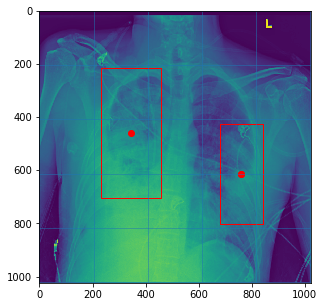

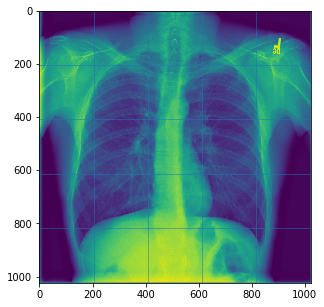

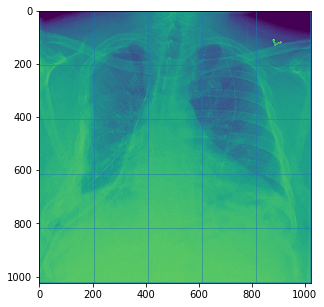

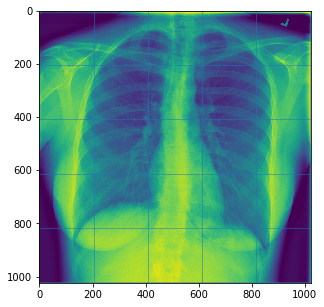

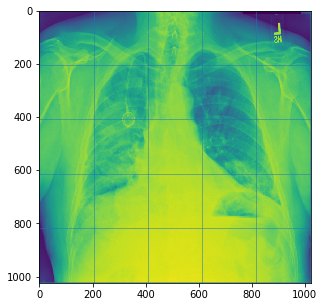

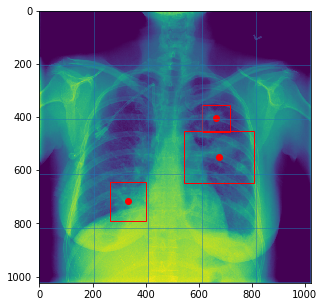

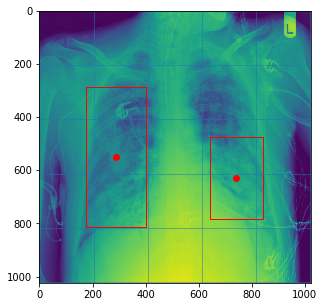

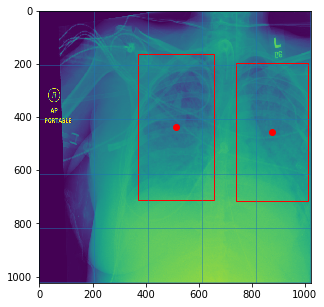

In [27]:
keys = list(pneumonia_locations.keys())

samples = np.random.choice(keys, size=5, replace=False)
coords = np.arange(0, 1024, CELL_WIDTH)

samples = list(samples) + ["0ab261f9-4eb5-42ab-a9a5-e918904d6356", "fffb2395-8edd-4954-8a89-ffe2fd329be3", "cb4a1fca-136c-4577-bcef-d934c9f14f2c"]

for filename in samples:
    # load the image
    img = pydicom.dcmread(os.path.join("stage_1_train_images", filename+".dcm")).pixel_array
    fig,ax = plt.subplots(1, figsize=(5,5))
    plt.imshow(img)
    
    # get the labels
    labels = pneumonia_locations[filename]
    
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            if labels[i,j,0] > 1e-16:
                x, y, w, h = labels[i,j,1:]
                w,h = w*1024, h*1024
                x = unnorm(x, j, CELL_WIDTH)
                y = unnorm(y, i, CELL_WIDTH)
                
                plt.plot(x, y, marker="o", color="r")
                
                x = x - (w / 2)
                y = y - (h / 2)
                
                rect_1 = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')
                ax.add_patch(rect_1)
    
    for item in coords:
        plt.axvline(item, linewidth=0.5)
        plt.axhline(item, linewidth=0.5)
        
    plt.show()